In [2]:
%matplotlib inline
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder, Normalizer, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.compose import make_column_transformer
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE 
from sklearn.feature_selection import GenericUnivariateSelect, chi2, SelectFpr, RFE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [3]:
train = pd.read_csv("data/final_loan_train.csv")
X_all = train.drop(columns=["loan_id","loan_success"])
Y_all = train["loan_success"]

print(X_all.shape)

categorical_cols = [col for col in X_all.columns if X_all[col].dtype == object]
scalar_cols = [col for col in X_all.columns if X_all[col].dtype != object]

cols = X_all.columns

scaler = make_column_transformer((MinMaxScaler(), scalar_cols), (OneHotEncoder(), categorical_cols))

scaler.fit_transform(X_all)
X_all = scaler.transform(X_all)


split_size = 3

(328, 44)


In [ ]:
def get_best_model(X, Y, models):
    best = None
    best_auc = 0
    best_params = {}
    best_rfe = None
    for model, params in models.items():
        print("Model: "+model.__class__.__name__, end="")
        rfe = RFE(model)
        pipeline = Pipeline([("smote", SMOTE(random_state=42)),
                             ("gus", rfe),
                             ("m", model)])
        kfold = StratifiedKFold(n_splits=4, shuffle=True)
        search = GridSearchCV(pipeline, params, n_jobs=-1 , scoring="roc_auc", cv=kfold).fit(X,Y)
        auc = search.best_score_

        print("\t auc: "+str(auc))
        if auc > best_auc:
            best, best_auc, best_rfe = model, auc, rfe
            best_params = { key.replace("m__", ""): value for key, value in search.best_params_.items()}
    return best, best_params , best_auc, best_rfe

In [5]:
models = {}

## Decision Tree

In [12]:
models[DecisionTreeClassifier()] = {}

## Log Reg

In [7]:
models[LogisticRegression()] = {
    "m__max_iter":[1000]
}

## Random Forest

In [13]:
models[RandomForestClassifier()] = {
    "m__n_estimators":[10, 100, 200, 1000],
    "m__criterion":["gini", "entropy"],
    "m__max_features":["auto", "sqrt", "log2"],
    "m__class_weight":["balanced", "balanced_subsample"]
}

## Get best model

In [14]:
model, best_params , auc, rfe = get_best_model(X_all,Y_all, models)
exec("model = "+model.__class__.__name__+"(**best_params)")
model, auc, rfe

Model: DecisionTreeClassifier	 auc: 0.660504313761356
Model: LogisticRegression	 auc: 0.648832388269008
Model: DecisionTreeClassifier	 auc: 0.6672798152551673
Model: DecisionTreeClassifier	 auc: 0.6547451374916163
Model: DecisionTreeClassifier	 auc: 0.7357207639778062
Model: DecisionTreeClassifier	 auc: 0.6904883848545821
Model: DecisionTreeClassifier	 auc: 0.6465337479421986
Model: RandomForestClassifier

KeyboardInterrupt: 

## Train model

In [9]:
model 

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       n_estimators=1000)

In [88]:
sm = SMOTE(random_state=42)
X_train, Y_train = sm.fit_resample(X_all, Y_all)
rfe.fit(X_train, Y_train)
X_train = rfe.transform(X_train)
model.fit(X_train, Y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       n_estimators=1000)

In [97]:
x = pd.DataFrame(X_all)
x = x.rename(columns={i:cols[i] for i in range(44)})
cols = x.columns

In [104]:
important = np.array(cols)[rfe.support_]
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

/tmp/ipykernel_17187/2581525092.py:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


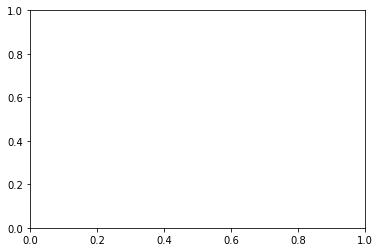

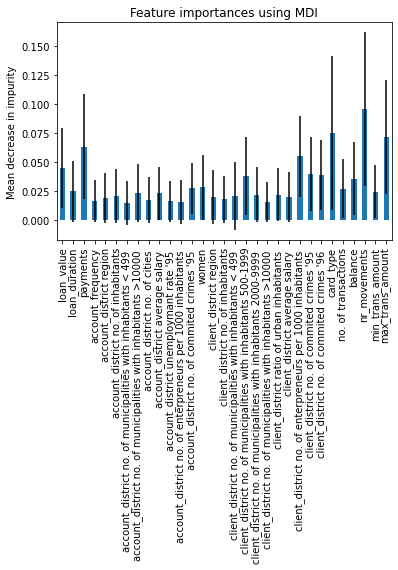

In [108]:
fig, ax = plt.subplots()
forest_importances = pd.Series(importances, index=important)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

# Save result

In [54]:
def saveModel(model):
    test = pd.read_csv("data/final_loan_test.csv")
    X = test.drop(columns=["loan_id","loan_success"])
    scaler.fit(X)
    X = scaler.transform(X)
    #rfe.fit(X_all, Y_all)
    X = rfe.transform(X)
    print(X.shape)
    Y = model.predict_proba(X)
    test["loan_success"] = pd.DataFrame(Y)[0]
    file_name = "("+str(int(auc*10000)/100.0)+")"+datetime.now().strftime("%H:%M_%Y.%m.%d")+"_"+model.__class__.__name__+"_prediction.csv"
    test[["loan_id","loan_success"]].rename(columns={"loan_id":"Id","loan_success":"Predicted"}).to_csv("predictions/"+file_name,index=False)
    print(file_name+" saved successfully")

In [75]:
if type(model) == list:
    for m in model:
        saveModel(m)
else:
    saveModel(model)

(354, 31)
(80.31)21:36_2021.12.13_RandomForestClassifier_prediction.csv saved successfully
